# QAOA (Quantum Approximate Optimization Algorithm)
#### Max-Cut Problem Implementation from the Qiskit Textbook

### Creating the Graph Representing the Quadrilateral 

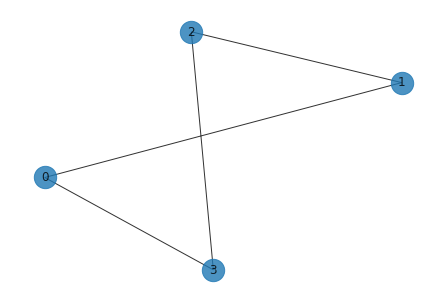

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

### The Initial State

C:\Users\vibus\AppData\Local\Temp\ipykernel_29356\4246882316.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


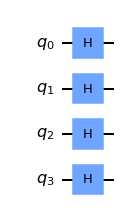

In [18]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are connected. 
# This matrix is given as a sparse matrix (mostly zero values), so we need to
# convert it to a dense matrix (non-zero values). Converting it limits the matrix from 
# taking up uneccesary space or computation time.
adjacency = nx.adjacency_matrix(G).todense()

numqubits = 4

qc_0 = QuantumCircuit(numqubits)
for i in range(0, numqubits):
    qc_0.h(i)
    
qc_0.draw(output='mpl')

### Mixing Unitary
This circuit below represents the “mixing” unitary. A unitary operator is essentially a linear operator whose inverse is its adjoint is called unitary.  A unitary operator preserves the "lengths" and "angles" between vectors, and it can be considered as a type of rotation operator in abstract vector space). This unitary will be applied interchangeably with the "cost" unitary.


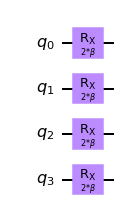

In [17]:
#$\\beta$ is to represent the beta as a symbol
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(numqubits)
for i in range(0, numqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw(output='mpl')

### Cost(Problem) Unitary

This circuit below represents the "cost" unitary. Essentially, the unitary represents the Hamiltonian that represents the goal/final state we want to be in. However in quantum computing every operation on a normalized quantum state must keep the sum of probabilities at 1 (you can't really have a total probability more than 1). Therefore, the Hamiltonian has been converted into a unitary which preserves the unique characteristrics of quantum (entaglement, coherence, superposition). This unitary will be applied interchangeably with the "cost" unitary.

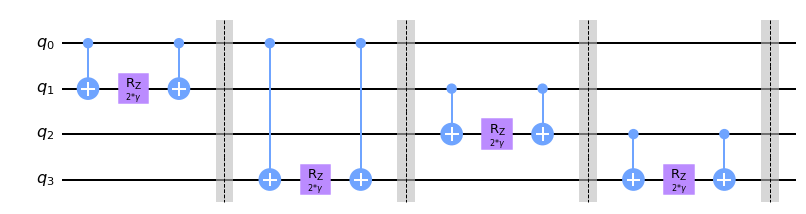

In [16]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(numqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw(output='mpl')

 Essentially we are trying to gradually transform the inital state into the final solution which is the cost unitary. To get to that state, ideally we would use a process called adiabatic quantum computation for a gradual shift. However, that is very time intensive and requires advanced hardware technology, something we currently do not have, so inorder to implement this on a gate based quantum computer, we will be rapidly applying two circuits interchangeably, to discretely shift the intial state to the final state. This process is called trotterization. Ideally if you have an infinite number of steps and choose angle parameters that are identical to the transofrmations that occur in the adiabatic path you will always get the correct results. However, we are only looking for an approximation and thus we start off with classically optimized values.

 Note: How have we encoded our solution into the "Cost" unitary you may ask? We want all the edges to connect different nodes so that we can cut the most amount of edges. We can translate this into the idea of having a chain of atomic particles that have a spin up (+1) or down (-1). We want each particle to have a different spin than its neighbors and can explain it as a chain or matrix. When rewritten as a matrix we can apply the pauli-Z matrix (represented by the Z gate) to change the behavior of the system, to mirror our solution.

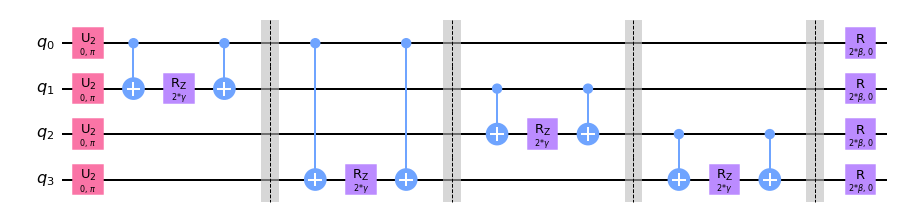

In [24]:
#Final Circuit
qc_qaoa = QuantumCircuit(numqubits)

qc_qaoa.append(qc_0, [i for i in range(0, numqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, numqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, numqubits)])

qc_qaoa.decompose().decompose().draw(output='mpl')
#U2 is the hadamard gate decomposed
#CNOT, RZ, CNOT is equivalent to a R_ZZ gate

### Implementing the Circuit

In [8]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: a list of paramters for the unitaries

    Returns:
        qc: qiskit circuit
    """
    
    numqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitary iterations
    qc = QuantumCircuit(numqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, numqubits):
        qc.h(i)
    
    for iteration in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[iteration], pair[0], pair[1])

        # mixer unitary
        for i in range(0, numqubits):
            qc.rx(2 * beta[iteration], i)
            
    qc.measure_all()
        
    return qc


#### Helper Functions for Classically Optimized Parameters

In [9]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            #It seems counter-intutive, but the goal is to minimize the objective we measure, 
            #so we are favoring these edges using a negative 1.
            obj -= 1
            
    return obj

In [10]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value (how many cuts will be made)
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    
    #returns the expected amount of cuts those measurement results
    return avg/sum_count

In [11]:
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        #seed simulator controls the random sampling from a simulator
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

### Implementing the Classical Optimization

In [12]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=3)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

### Executing the Optimized Circuit + Plotting the Results

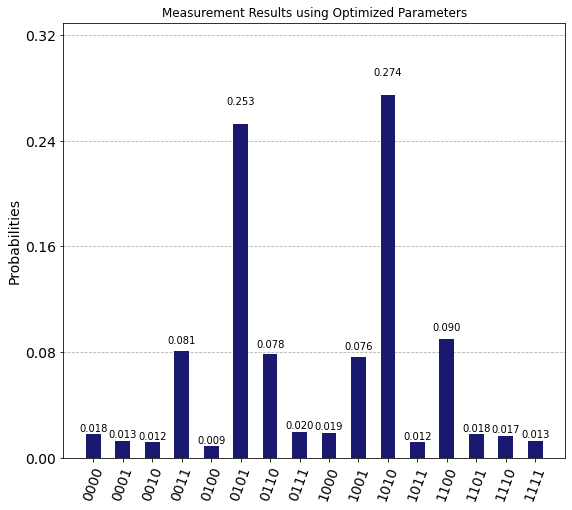

In [30]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

#using the optimized parameters for the circuit
qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts, figsize = (9,8), color='midnightblue', title="Measurement Results using Optimized Parameters")